# CLASS-HDS Demo

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from classy import Class

In [8]:
# Evoke class, set parameters and solve Einstein-Boltzmann

def get_hds_background(phi_i):
    c = Class()
    pars = {
        # Cosmological parameters
        "H0": 67.56,
        "omega_b": 0.022,
        "omega_cdm": 0.12,
        "A_s": 2.215e-9,
        "n_s": 0.962,
        "tau_reio": 0.0544,
        "N_ur": 3.044,
        "N_ncdm": 0,
        "Omega_Lambda": 0.0,
        "Omega_fld": 0.0,
        "Omega_scf": -1.0, # NOTE: setting negative values of Omega_scf will trigger the shooting
        "scf_parameters": f"100,{phi_i}", # NOTE: scf_parameters is organized as follows: the first index represents V0 (it shoots so the value does not matter), the second represents the field initial value
        "YHe": 0.24,
        "scf_tuning_index": 0,
        # CLASS settings
        "lensing": "yes",
        "non_linear": "hmcode",
        "output": "mPk,tCl,pCl,lCl",
        "l_max_scalars": 3000,
        "P_k_max_h/Mpc": 10
    }
    c.set(pars)
    c.compute()
    bg = c.get_background()
    z = bg["z"]
    rho_cdm = bg["(.)rho_cdm"]
    rho_b = bg["(.)rho_b"]
    rho_nu_massless = bg["(.)rho_ur"]
    rho_phot = bg["(.)rho_g"]
    rho_scf = bg["(.)rho_scf"]
    rho_tot = bg["(.)rho_tot"]
    return bg

def get_densities_from_bg(bg):
    z = bg["z"]
    rho_cdm = bg["(.)rho_cdm"]
    rho_b = bg["(.)rho_b"]
    rho_nu_massless = bg["(.)rho_ur"]
    rho_phot = bg["(.)rho_g"]
    rho_scf = bg["(.)rho_scf"]
    rho_tot = bg["(.)rho_tot"]
    return z, rho_cdm, rho_b, rho_phot+rho_nu_massless, rho_scf, rho_tot

def get_fractions_from_bg(bg):
    z = bg["z"]
    rho_cdm = bg["(.)rho_cdm"]
    rho_b = bg["(.)rho_b"]
    rho_nu_massless = bg["(.)rho_ur"]
    rho_phot = bg["(.)rho_g"]
    rho_scf = bg["(.)rho_scf"]
    rho_tot = bg["(.)rho_tot"]
    return z, rho_cdm/rho_tot, rho_b/rho_tot, (rho_phot+rho_nu_massless)/rho_tot, rho_scf/rho_tot

In [3]:
bg_8 = get_hds_background(8)
bg_10 = get_hds_background(10)

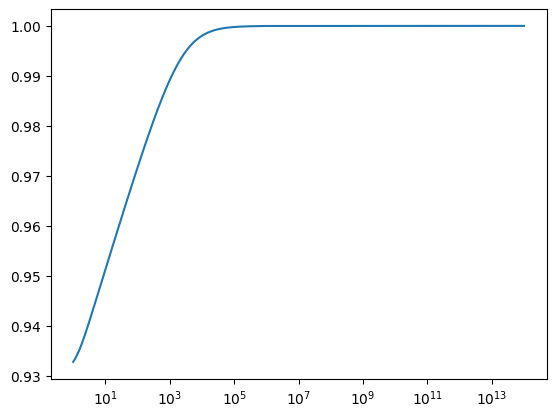

In [7]:
plt.semilogx(1 + bg_8['z'], bg_8['phi_scf']/8)

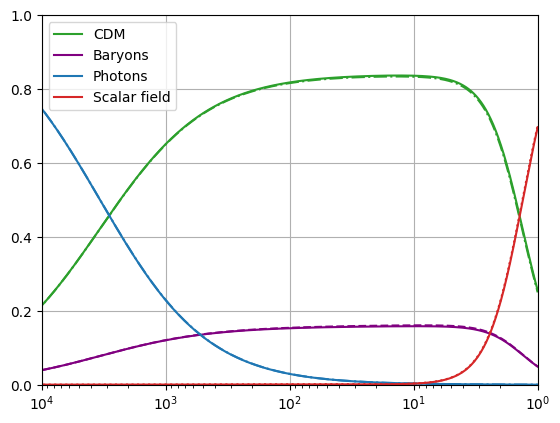

In [5]:
z, rho_cdm_8, rho_b_8, rho_r_8, rho_scf_8, rho_tot_8 = get_densities_from_bg(bg_8)
z, rho_cdm_10, rho_b_10, rho_r_10, rho_scf_10, rho_tot_10 = get_densities_from_bg(bg_10)

plt.semilogx(1+z, rho_cdm_10/rho_tot_10, color="tab:green", label="CDM")
plt.semilogx(1+z, rho_cdm_8/rho_tot_8, color="tab:green", ls="-.")
plt.semilogx(1+z, rho_b_10/rho_tot_10, color="purple", label="Baryons")
plt.semilogx(1+z, rho_b_8/rho_tot_8, color="purple", ls="--")
plt.semilogx(1+z, rho_r_10/rho_tot_10, color="tab:blue", label="Photons")
plt.semilogx(1+z, rho_r_8/rho_tot_8, color="tab:blue", ls="-.")
plt.semilogx(1+z, rho_scf_10/rho_tot_10, color="tab:red", label="Scalar field")
plt.semilogx(1+z, rho_scf_8/rho_tot_8, color="tab:red", ls=":")
plt.xlim([1e4, 1])
plt.ylim([0, 1])
plt.legend()
plt.grid()

In [12]:
z, f_cdm, f_b, f_r, f_scf = get_fractions_from_bg(bg_8)
omega_m = (0.022 + 0.12)/(0.6756)**2
omega_scf = 1 - omega_m
actual_omega_m = f_cdm[-1] + f_b[-1]
actual_omega_scf = f_scf[-1]
print(omega_m, actual_omega_m)
print(omega_scf, actual_omega_scf)

0.31110648394988505 0.29873560509074065
0.688893516050115 0.7011711021660471


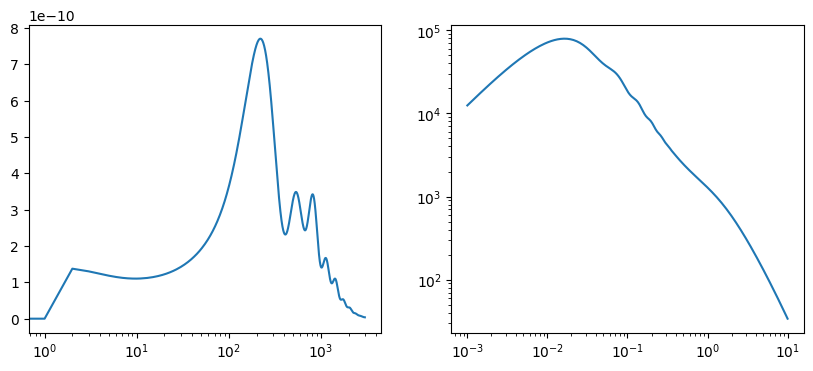

In [49]:
# Extracting P(k) and temperature C_l
h = 0.6732
k = np.logspace(-3, 1, 200) # In h/Mpc
z = np.zeros(1)
pk = c.get_pk_array(k*h, z, len(k), 1, True) # NOTE: this function assumes k in 1/Mpc
class_cls = c.lensed_cl()
ells = class_cls['ell']
cls = ells*(ells+1)*class_cls['tt']/(2*np.pi)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].semilogx(ells, cls)
axs[1].loglog(k, pk)